In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from IPython.display import clear_output


In [3]:
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=[512, 256, 128], dropout_rate=0.3):
        super(MLPClassifier, self).__init__()
        layers = []
        prev_size = input_size
        for size in hidden_size:
            layers.append(nn.Linear(prev_size, size))
            layers.append(nn.BatchNorm1d(size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = size

        layers.append(nn.Linear(prev_size, 10))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [4]:
dataset = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [5]:
torch.cuda.is_available()

True

In [6]:
device = torch.device('cuda')

In [7]:
X = dataset.drop('label', axis=1).values.astype(np.float32) / 255.0
y = dataset['label'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123)

In [8]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)

In [9]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

In [10]:
batch_size = 256 
num_workers = 4 
pin_memory = True 

In [11]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=pin_memory, persistent_workers=True)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=pin_memory, persistent_workers=True)

In [12]:
input_size = 784
model = MLPClassifier(input_size = input_size).to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-3)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1) # В целом показывает себя неплохо
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95) # Хуй пойми, ничего особенного в целом

In [14]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)
    
    return total_loss, correct / total

In [15]:
def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
    return total_loss, correct / total

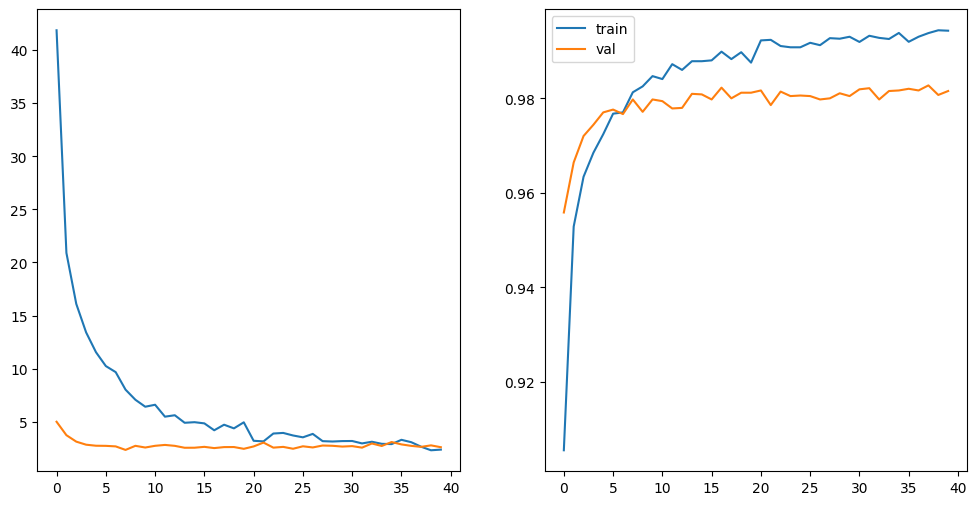

In [16]:
num_epochs = 40
train_loss_arr = []
train_acc_arr = []

val_loss_arr = []
val_acc_arr = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    train_loss_arr.append(train_loss)
    train_acc_arr.append(train_acc)
    val_loss_arr.append(val_loss)
    val_acc_arr.append(val_acc)
    clear_output()
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].plot(train_loss_arr, label='train')
    axes[0].plot(val_loss_arr, label='val')
    axes[1].plot(train_acc_arr, label='train')
    axes[1].plot(val_acc_arr, label='val')
    plt.legend()
    plt.show()

In [18]:
test_data = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
X_test = test_data.values.astype(np.float32) / 255.0

X_test_tensor = torch.FloatTensor(X_test)
test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=pin_memory, persistent_workers=True)

In [19]:
model.eval()
preds = []
with torch.no_grad():
    for data in test_loader:
        data = data[0].to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        preds.extend(pred.cpu().numpy())

In [20]:
submission = pd.DataFrame(
    {'ImageId': range(1, len(preds) + 1),
    'Label': preds}
)

submission.to_csv('s.csv', index=False)